# Noisy entries analysis

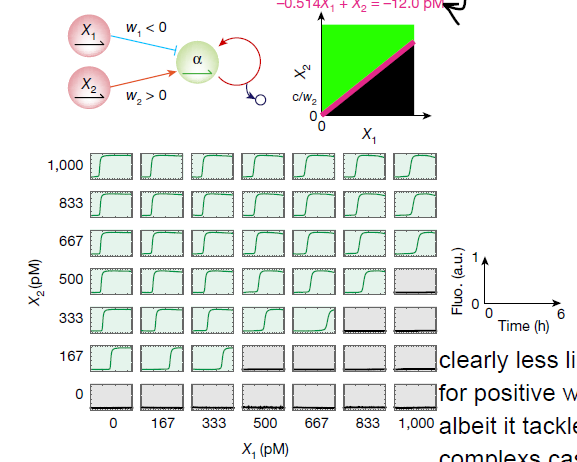

Below, the system with deterministic entries

## 1. Initial output concentration $y_0$ and destroyed ability to classify

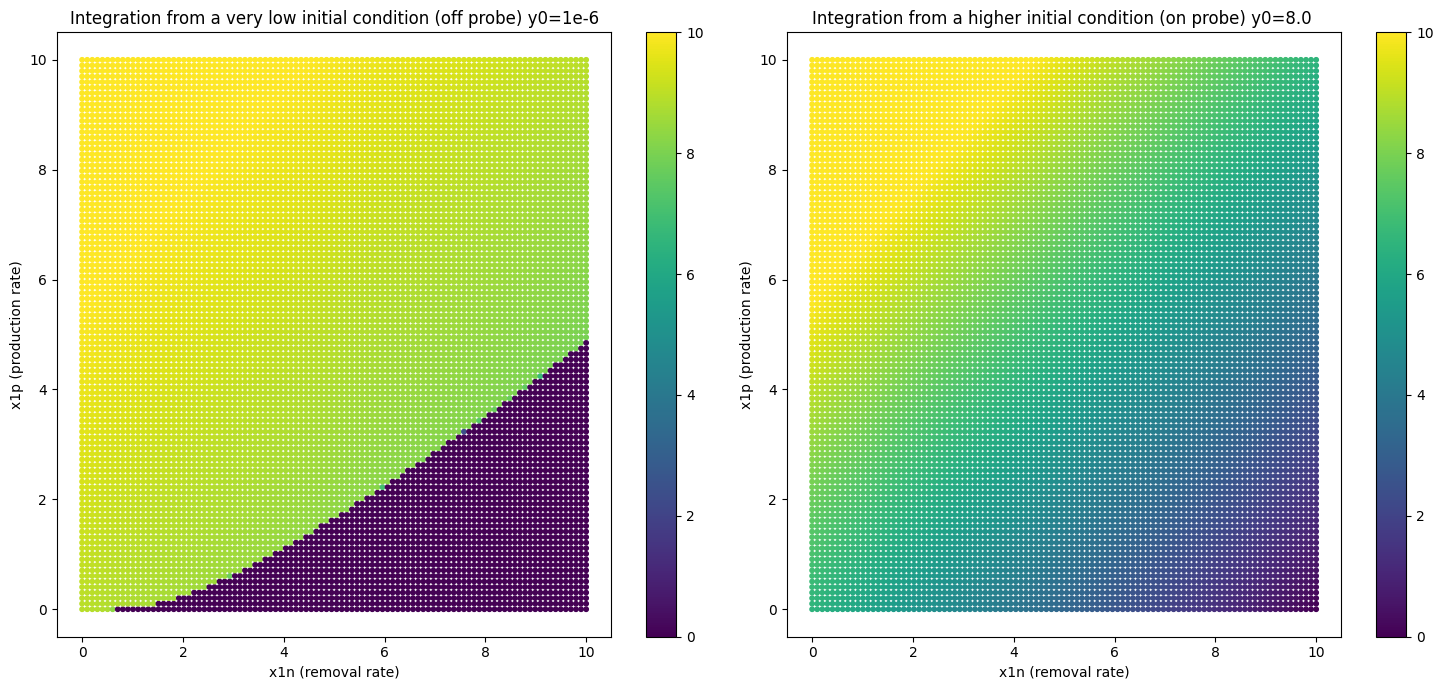

The system display tree fixed points (one unstable steady state in the middle (e.g., a saddle point) and 2 stable steady states located on either side (low and high branches). If we start close to the low one (e.g., y0=1e-6), the system will relax to the low steady state (i.e. the rule "choose the lowest fixed point", when no ambiguity is probed). If we start close to the high branch (e.g., y0=8.0), the system will relax to the high steady state (i.e. the rule "choose the highest fixed point", when no ambiguity is probed). Nevertheless, the physical case is the first one, as y being a product of the CRN, we always start from low values of $y_0$.

On the second plot, we can see that starting from a non 0 concentration of $y_0$ completely destroy the networks ability to classifie the space : indeed, we don't start from a given state (off/on) but from an ambiguous mixture.

## 2. Constant gaussian white noise (when we can talk about concentration)

### 2.1 Phase diagram

We here rather consider concentration. Now, we assume that the dropplet are ingeenred to have a certain given value, yet there exists intrinsic fluctuations. As fluctuations are assumed to be independants btw each others wrt to time and space (white), and considering CLTn we choose a gaussian white noise, where the concentration value is drawn from $x=x_{grid}+\eta$. For now, the noise is time independant


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm  # For progress bar
from itertools import product
from matplotlib.collections import LineCollection

# --- Parameters ---
delta = 0.1
k_s = 0.02
b = 0.005

# ODE definition: given x1p and x1n parameters in the rate functions
def dy_dt(t, y, delta, x1p, x1n, k_s):
    return y / (1 + y) - delta * y + 0.017 * x1p - (y * (b + 0.017 * x1n)) / (k_s + y)

# Integration helper function
def integrate_ode(x1p, x1n, y0, t_span, t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 2000)
    sol = solve_ivp(dy_dt, t_span, [y0],
                    args=(delta, x1p, x1n, k_s),
                    t_eval=t_eval,
                    method='RK45', rtol=1e-8, atol=1e-10)
    return sol.y[0, -1]

# Correct Discriminant Function Δ(x1n, x1p)
def discriminant(x1p, x1n):
    return (0.000135648
            + 8.3521e-8 * x1n**4
            + x1n**3 * (-0.0000108676 - 3.30743e-7 * x1p)
            + x1n**2 * (0.00024844 + (0.0000318443 + 4.91137e-7 * x1p) * x1p)
            + x1n * (-0.000361051 + x1p * (-0.00044181 + (-0.0000310883 - 3.24128e-7 * x1p) * x1p))
            + x1p * (-0.000607421 + x1p * (0.000193247 + (0.0000101115 + 8.02136e-8 * x1p) * x1p)))

# --- Parameter grid for numerical integration (for the full phase diagram) ---
nb_of_points = 50
x1p_grid = np.linspace(0, 10, nb_of_points)
x1n_grid = np.linspace(0, 10, nb_of_points)

# Noise parameters
noise_sigma = 0.2  # standard deviation of the Gaussian noise

# Time span and initial condition for the ODE
t_span_full = (0, 150)
y0 = 1e-6  # initial concentration

# --- Generate data ---
results = []  # to store (noisy x1p, noisy x1n, steady state)
for x1p, x1n in tqdm(product(x1p_grid, x1n_grid), total=nb_of_points*nb_of_points):
    # Add independent Gaussian white noise to each grid coordinate
    noisy_x1p = x1p + np.random.normal(loc=0, scale=noise_sigma)
    noisy_x1n = x1n + np.random.normal(loc=0, scale=noise_sigma)
    
    # Integrate the ODE dynamics with the noisy parameters
    y_low = integrate_ode(noisy_x1p, noisy_x1n, y0, t_span=t_span_full)
    
    # Clip y_low into a reasonable range (0 to 10) for visualization
    results.append((noisy_x1p, noisy_x1n, np.clip(y_low, 0, 10)))

results = np.array(results)
x1p_plot = results[:, 0]
x1n_plot = results[:, 1]
y_low_plot = results[:, 2]



  0%|          | 0/2500 [00:00<?, ?it/s]

Rmq : this is a plain ODE solver without previous optimization (keeping the lowest fp, or if ambiguous, computing the concentration)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14788\3215989722.py:18: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(X1N, X1P, delta_vals_masked, levels=[0], colors='r', linewidths=1,


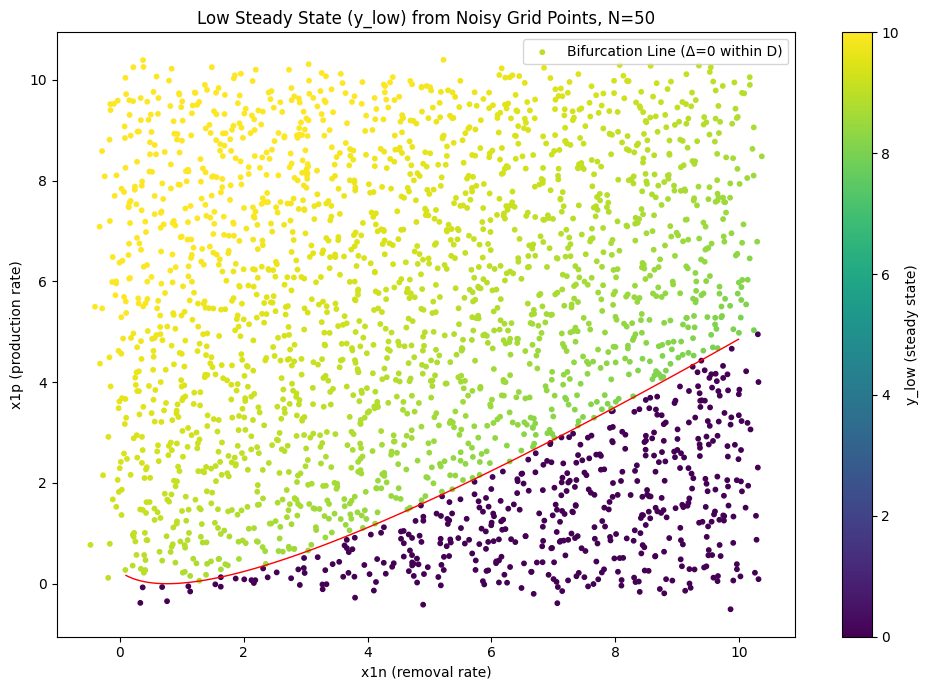

In [7]:
# --- Plot the phase diagram using the noisy grid points ---
fig, ax = plt.subplots(figsize=(10, 7))
sc = ax.scatter(x1n_plot, x1p_plot, c=y_low_plot, cmap='viridis', s=10, marker='o')
ax.set_title(f"Low Steady State (y_low) from Noisy Grid Points, N={nb_of_points}")
ax.set_xlabel("x1n (removal rate)")
ax.set_ylabel("x1p (production rate)")
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("y_low (steady state)")

# Overlay the bifurcation line (Δ(x1n, x1p) = 0) based on the original grid:
a = 2  # Domain condition parameter: x1p - a*x1n < 0
x1n_vals = np.linspace(0, 10, 1000)
x1p_vals = np.linspace(0, 10, 1000)
X1N, X1P = np.meshgrid(x1n_vals, x1p_vals)
delta_vals = discriminant(X1P, X1N)
domain_mask = (X1P - a * X1N) < 0
delta_vals_masked = np.ma.array(delta_vals, mask=~domain_mask)
ax.contour(X1N, X1P, delta_vals_masked, levels=[0], colors='r', linewidths=1, 
           label="Bifurcation Line (Δ=0 within D)")

ax.legend(["Bifurcation Line (Δ=0 within D)"])
plt.tight_layout()
plt.show()


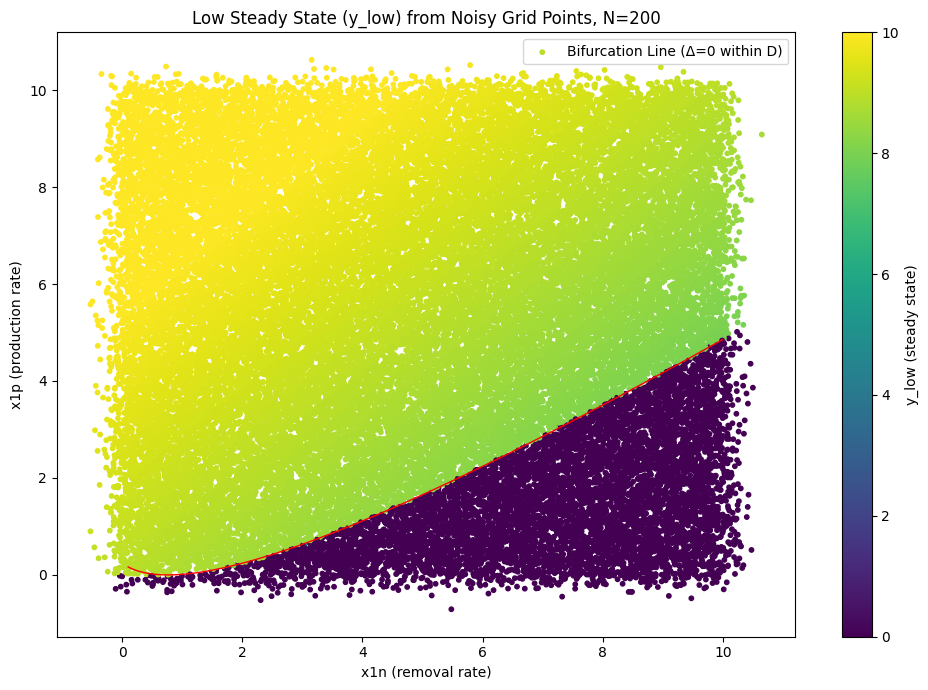

Rmk : We shall keep in mind that the analytical contour and the time simulation are just both come from the same chemical kinetic equation.


### 2.2 Diagonal concentration profile

Let us now study the y density profile along the $(0,10)\rightarrow(10,0)$ diagonal, as a function of the computation time of the CRN. 

In [17]:
# -----------------------------------------------------------------
# Study the Evolution of the Density Profile as a Function of tf
# -----------------------------------------------------------------

# Parameterize the diagonal from (0,10) to (10,0):
# Using parameter t in [0, 1]:
#     x1n = 10*t,   x1p = 10*(1-t)
num_points = 200
t_line = np.linspace(0, 1, num_points)
x1n_diag = 10 * t_line
x1p_diag = 10 * (1 - t_line)
# Compute physical distance along the diagonal: L = 10*sqrt(2)*t
distance_diag = 10 * np.sqrt(2) * t_line

# Noise parameters
noise_sigma = 0.2  # standard deviation of the Gaussian noise

# Define a set of final integration times tf to study
tf_list = [2, 10, 30, 200]

# Compute the density profiles along the diagonal for each tf
profiles = {}
for tf in tqdm(tf_list, desc="Processing tf values"):
    y_profile = np.zeros(num_points)
    for i in tqdm(range(num_points), desc=f"tf = {tf}", leave=False):
        # Gaussian noise added for each parameter
        noisy_x1p = x1p_diag[i] + np.random.normal(loc=0, scale=noise_sigma)
        noisy_x1n = x1n_diag[i] + np.random.normal(loc=0, scale=noise_sigma)
        
        # Integrate using the noisy parameters
        y_profile[i] = integrate_ode(noisy_x1p, noisy_x1n, y0=1e-6, t_span=(0, tf))
    profiles[tf] = y_profile

# Determine global min and max among profiles for color mapping the y-values
all_y = np.concatenate(list(profiles.values()))
y_min, y_max = all_y.min(), all_y.max()
norm_y = plt.Normalize(vmin=y_min, vmax=y_max)
cmap_y = plt.cm.viridis

# Set desired plot ranges for the profile plots
x_min = 5      # left x-limit
x_max = 12.5
y_min_plot = 0
y_max_plot = 12.5

# Compute the annotation index (the first point within the x-range)
annotate_index = np.where(distance_diag >= x_min)[0][0]

# --- Compute the bifurcation location along the diagonal ---
# Evaluate the discriminant along the diagonal (with x1p_diag and x1n_diag)
delta_diag = discriminant(x1p_diag, x1n_diag)
# Find the index where the absolute value is minimal (closest to zero)
bif_index = np.argmin(np.abs(delta_diag))
bif_distance = distance_diag[bif_index]





Processing tf values:   0%|          | 0/4 [00:00<?, ?it/s]

tf = 2:   0%|          | 0/200 [00:00<?, ?it/s]

tf = 10:   0%|          | 0/200 [00:00<?, ?it/s]

tf = 30:   0%|          | 0/200 [00:00<?, ?it/s]

tf = 200:   0%|          | 0/200 [00:00<?, ?it/s]

**(a) With noise**

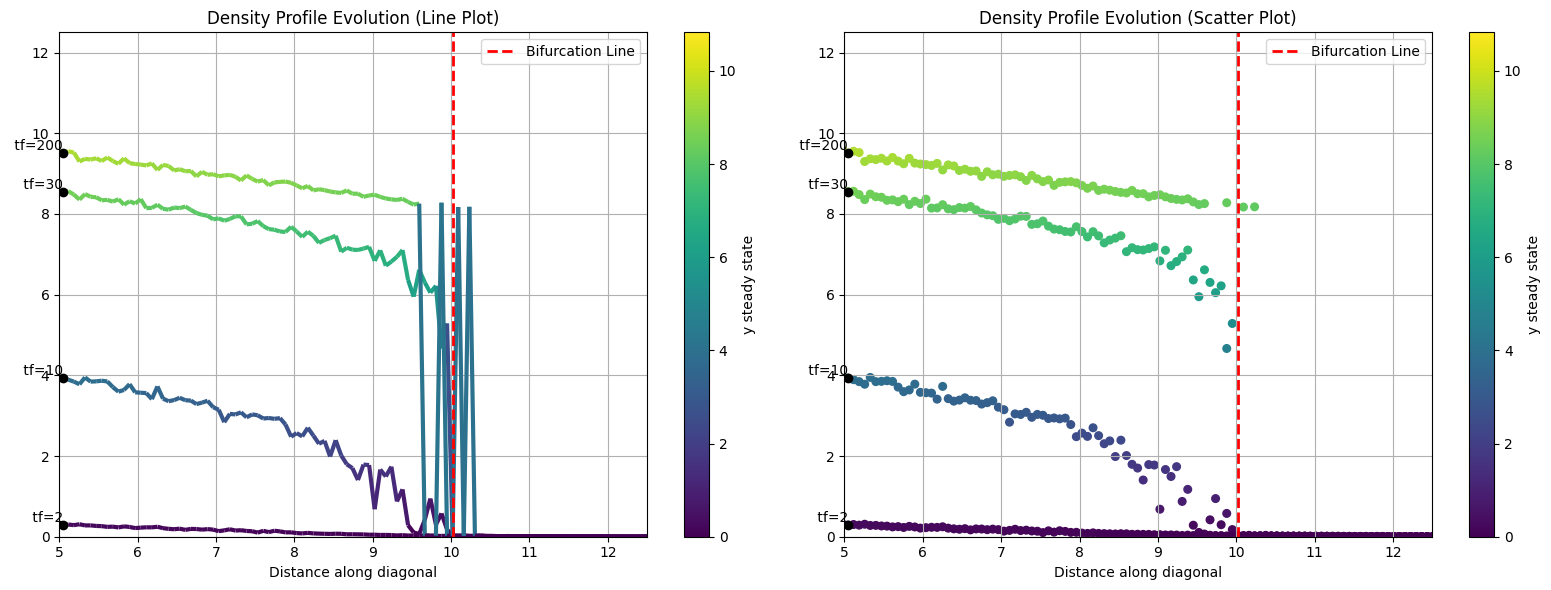

In [18]:
# Set desired plot ranges.
x_min = 5    # left x-limit
x_max = 12.5
y_min_plot = 0
y_max_plot = 12.5

# Create a single figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# -----------------------------------------------------------------
# Left Plot (ax1): Line Plot Using LineCollection with updated annotation point
# -----------------------------------------------------------------
for tf in tf_list:
    y_profile = profiles[tf]
    # Build the points array for the profile: shape (num_points, 2)
    points = np.array([distance_diag, y_profile]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Assign colors to each segment based on the average y value
    seg_colors = []
    for i in range(len(segments)):
        y_seg_avg = (y_profile[i] + y_profile[i+1]) / 2.0
        seg_colors.append(cmap_y(norm_y(y_seg_avg)))
    
    # Create and add the LineCollection for this profile
    lc = LineCollection(segments, colors=seg_colors, linewidths=3)
    ax1.add_collection(lc)
    
    # Annotate the first visible point for this profile.
    left_distance = distance_diag[annotate_index]
    left_y = y_profile[annotate_index]
    ax1.plot(left_distance, left_y, 'ko', markersize=6)
    ax1.text(left_distance, left_y, f' tf={tf}', fontsize=10, va='bottom', ha='right')

# --- Add the red vertical line for the bifurcation location in ax1 ---
ax1.axvline(bif_distance, color='red', linestyle='--', linewidth=2, label='Bifurcation Line')

ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min_plot, y_max_plot)
ax1.set_xlabel("Distance along diagonal")
ax1.set_title("Density Profile Evolution (Line Plot)")
ax1.grid(True)

# Add a colorbar for the left plot
sm1 = plt.cm.ScalarMappable(cmap=cmap_y, norm=norm_y)
sm1.set_array([])
cbar1 = plt.colorbar(sm1, ax=ax1)
cbar1.set_label("y steady state")
ax1.legend()

# -----------------------------------------------------------------
# Right Plot (ax2): Scatter Plot
# -----------------------------------------------------------------
for tf in tf_list:
    y_profile = profiles[tf]
    # Scatter plot: Each point's color is determined by its y value.
    # NOTE: The label parameter is removed here so TF entries do not appear in the legend.
    ax2.scatter(distance_diag, y_profile, c=y_profile, cmap=cmap_y,
                norm=norm_y, s=30)
    
    # Annotate the first visible point for this profile.
    left_distance = distance_diag[annotate_index]
    left_y = y_profile[annotate_index]
    ax2.plot(left_distance, left_y, 'ko', markersize=6)
    ax2.text(left_distance, left_y, f' tf={tf}', fontsize=10, va='bottom', ha='right')

# --- Also add the red vertical line for the bifurcation location in ax2 ---
ax2.axvline(bif_distance, color='red', linestyle='--', linewidth=2, label='Bifurcation Line')

ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min_plot, y_max_plot)
ax2.set_xlabel("Distance along diagonal")
ax2.set_title("Density Profile Evolution (Scatter Plot)")
ax2.grid(True)

# Add a colorbar for the right plot
sm2 = plt.cm.ScalarMappable(cmap=cmap_y, norm=norm_y)
sm2.set_array([])
cbar2 = plt.colorbar(sm2, ax=ax2)
cbar2.set_label("y steady state")

# With only the red line labeled in ax2, the legend will show just that.
ax2.legend()

plt.tight_layout()
plt.show()

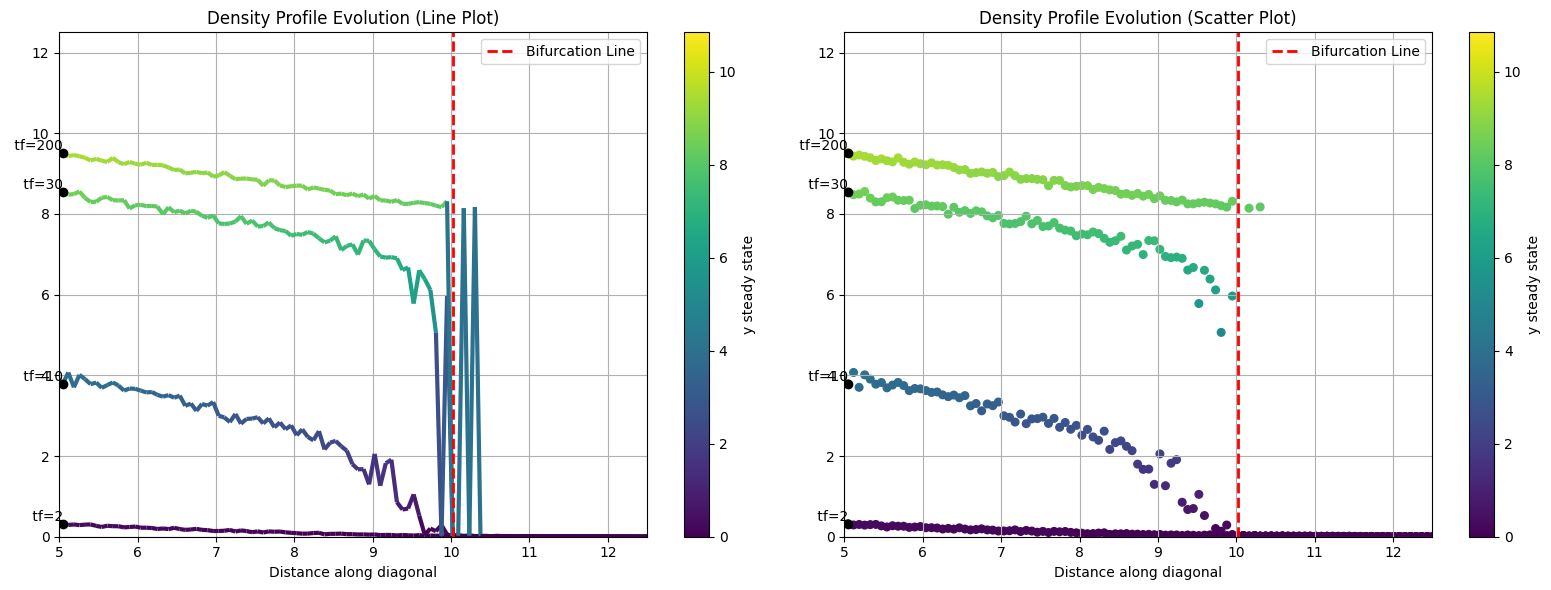

Early stopping ($t_f=2,...,10,...$) of the CRN computation freeze most of neurons/dropplets in an undecized state (wich is the off one as we start from low $y_0$ values).Therefore, the classification frontiere ends up blurry if not completely absent. Increasing the computation time leads the frontier to converges toward a treshold value : the whole system reaches a stable/decided state for classification.

Below, near the frontier, due to stochastic fluctuations, we can find on of off points which are not like their neightbors (this is why we see switch in the line plot).

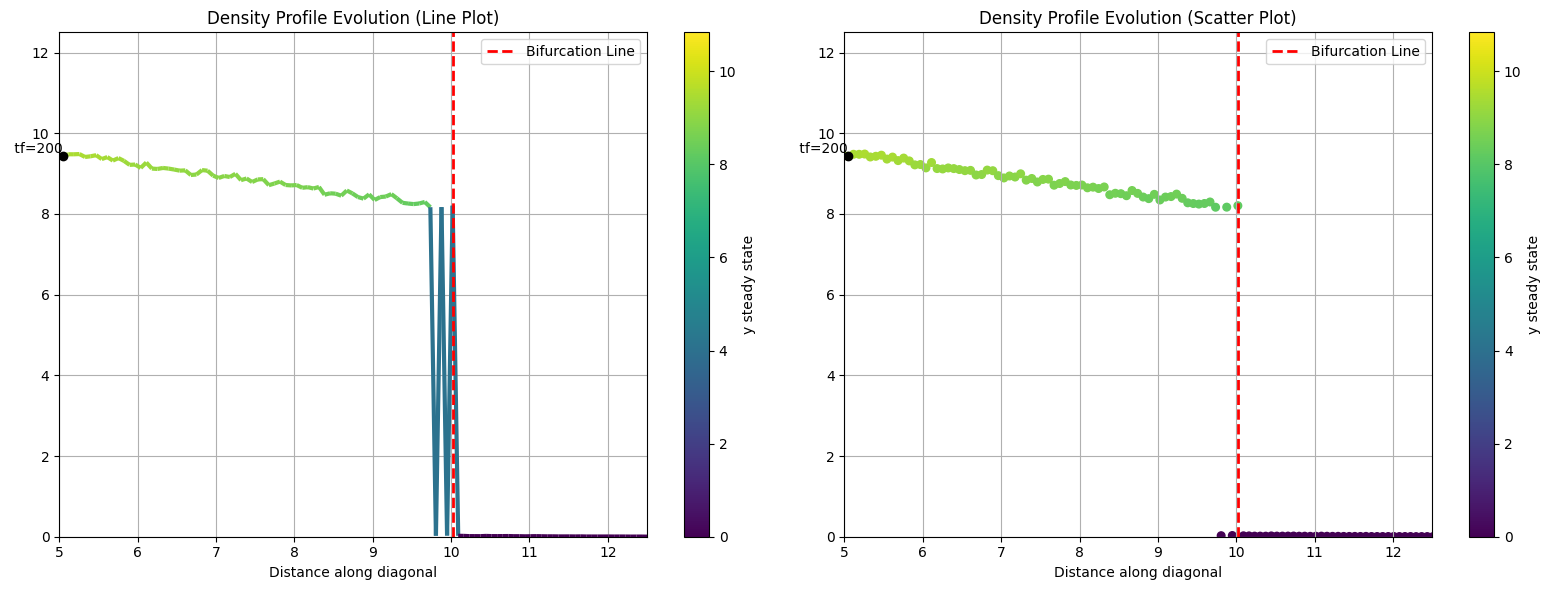

**les autres points sont des erreurs, faux positifs et faux negatifs**

**(b) Without noise**

Below, the no noise deterministic case gives rise to a clear classification, without inversed-classified points on both sides of the demarcation line. Hence, noise on the entries leads tpo small fluctuations of classification on both side of the deterministic demarcation line.

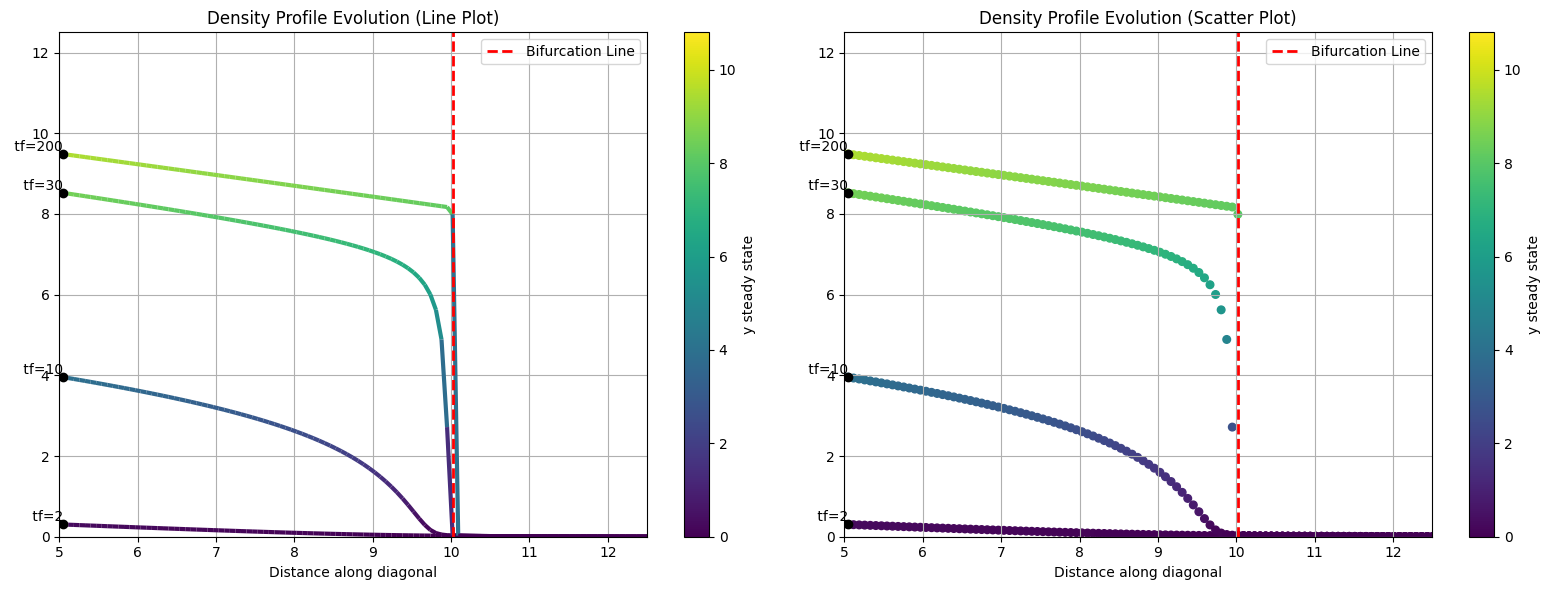

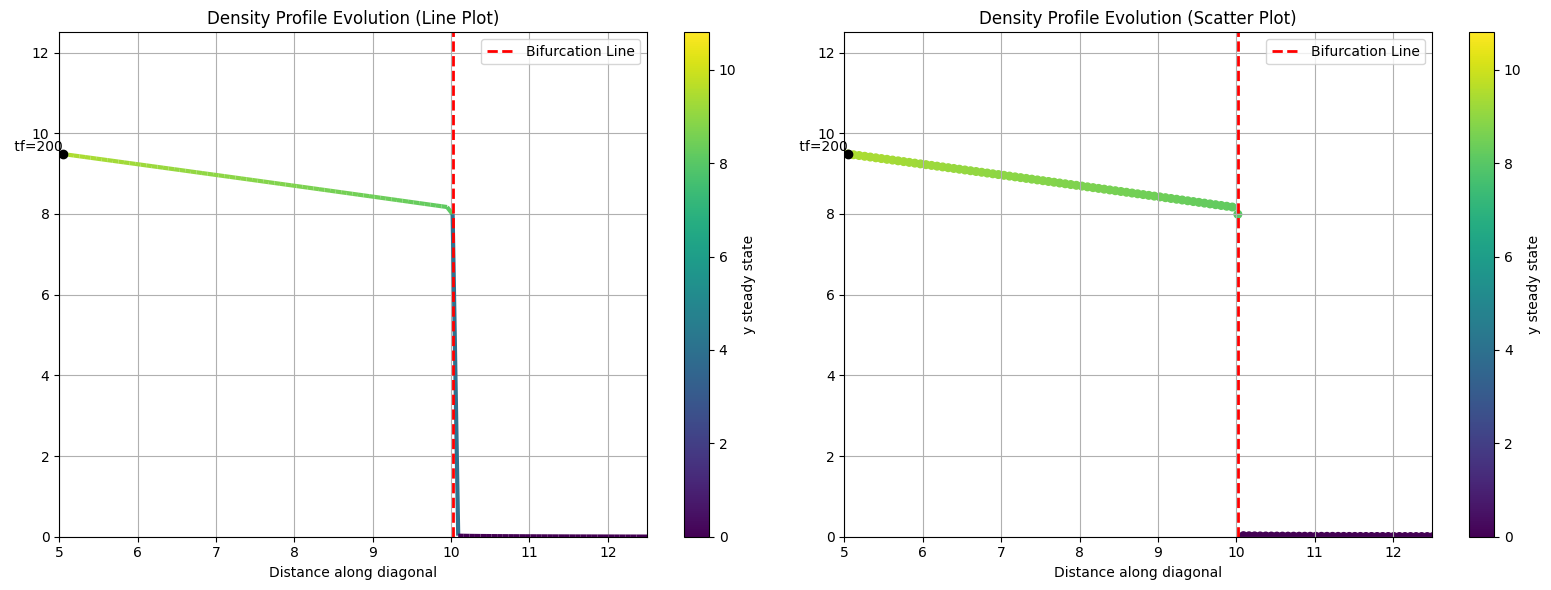

### 2.3 Convergence time 

**(a) Convergence for each neuron toward their decided state**

We can try to get an idea of the order neaded for all neuron to have reached their decided/steady state.

Integrating y(t):   0%|          | 0/2500 [00:00<?, ?it/s]

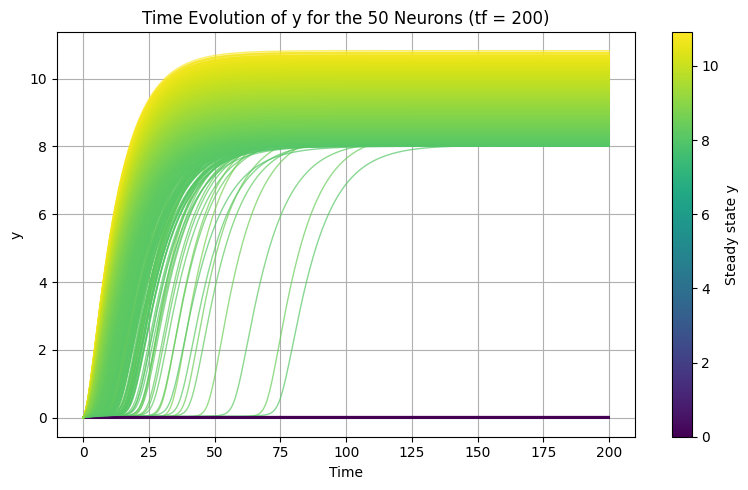

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm  # For progress bar

# Assumed external definitions:
# - dy_dt (ODE definition)
# - delta, k_s, and other parameters (should be defined as in your previous code)
# - cmap_y and norm_y are set up for color mapping according to the steady state y values.

# Noise parameters (same as in your previous code)
noise_sigma = 0.2  # standard deviation of the Gaussian white noise

# -----------------------------------------------------------------
# Plot y(t) for all neurons (entire grid) from t=0 to a single tf value
# to visualize convergence speed to the classified state.
# -----------------------------------------------------------------

# Choose a single final time for the integration
tf_single = 200
t_eval_single = np.linspace(0, tf_single, 500)

# Define the grid of neurons (if not already defined):
nb_of_points_grid = 50
x1p_values = np.linspace(0, 10, nb_of_points_grid)
x1n_values = np.linspace(0, 10, nb_of_points_grid)
all_neurons = [(x1p, x1n) for x1p in x1p_values for x1n in x1n_values]

fig5, ax5 = plt.subplots(figsize=(8, 5))

# Loop over the grid to compute and plot y(t) for each neuron.
for x1p, x1n in tqdm(all_neurons, total=len(all_neurons), desc="Integrating y(t)"):
    
    # Add Gaussian white noise to the grid parameters
    noisy_x1p = x1p + np.random.normal(loc=0, scale=noise_sigma)
    noisy_x1n = x1n + np.random.normal(loc=0, scale=noise_sigma)
    
    sol = solve_ivp(dy_dt, (0, tf_single), [1e-6],
                    args=(delta, noisy_x1p, noisy_x1n, k_s),
                    t_eval=t_eval_single,
                    method="RK45", rtol=1e-8, atol=1e-10)
    y_vals = sol.y[0]
    
    # Color the curve according to the steady state value (final y value)              
    color = cmap_y(norm_y(y_vals[-1]))
    ax5.plot(sol.t, y_vals, color=color, lw=1, alpha=0.7)

ax5.set_xlabel("Time")
ax5.set_ylabel("y")
ax5.set_title(f"Time Evolution of y for the {nb_of_points_grid} Neurons (tf = {tf_single})")
ax5.grid(True)

# Add a colorbar for the final y values which indicate the classified state
sm = plt.cm.ScalarMappable(cmap=cmap_y, norm=norm_y)
sm.set_array([])
cbar5 = plt.colorbar(sm, ax=ax5)
cbar5.set_label("Steady state y")

plt.tight_layout()
plt.show()


We've ploted here the concentration of y for all neurons as a function of time. An approximation of such a time for the CRN (N=50) to fully operate the classification would be of the ordre of $\tau\approx 125$. It seems that the more you add neuron, the longer it takes to be sure that all neurons have reached their decided/steady state value
Yet  this is a purely stochastic artifact, because increasing the number of neurons increases the proba to be very near the demarcation line, ie the bifurcation point (i.e. very near the frontier between the 2 bassins of attraction), whose convergence from is expected to be longer and longer.

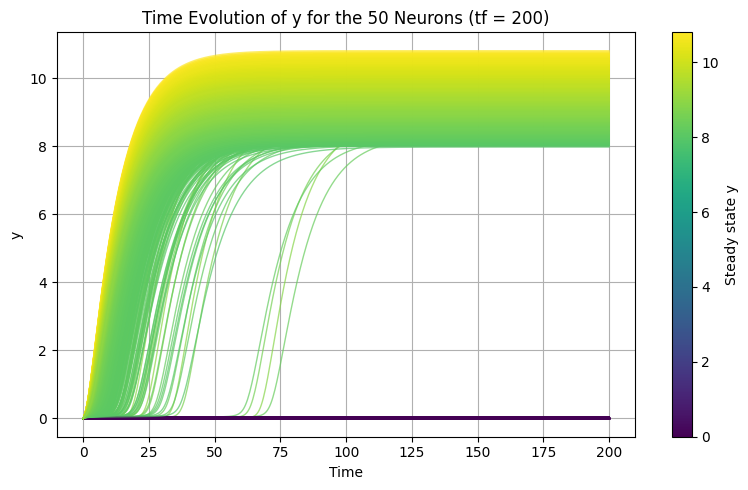 
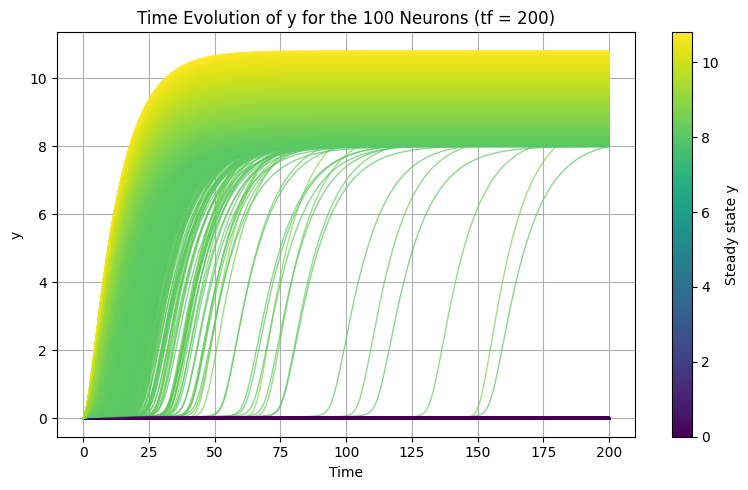

Rmk : up to now, we've used the following time unit $\tau=t(sc)V\cdot aT/K$ with V, K and aT are respectively - for the autocathalytic process - the turnover number (inverse of a time), K the Michaelis constant (concentration) and aT the autocathalitic template concentration, involved in $\alpha'(t)=\frac{V aT \alpha(t)}{K+\alpha(t)}+ \text{other processes}$

**(b) Convergence time of the whole classifier**


Processing grid with nb_of_points_grid = 30 (total neurons: 900)


Integrating for grid 30:   0%|          | 0/900 [00:00<?, ?it/s]

Grid size 30: 95% convergence reached at t ≈ 88.98

Processing grid with nb_of_points_grid = 60 (total neurons: 3600)


Integrating for grid 60:   0%|          | 0/3600 [00:00<?, ?it/s]

Grid size 60: 95% convergence reached at t ≈ 88.58

Processing grid with nb_of_points_grid = 90 (total neurons: 8100)


Integrating for grid 90:   0%|          | 0/8100 [00:00<?, ?it/s]

Grid size 90: 95% convergence reached at t ≈ 88.58


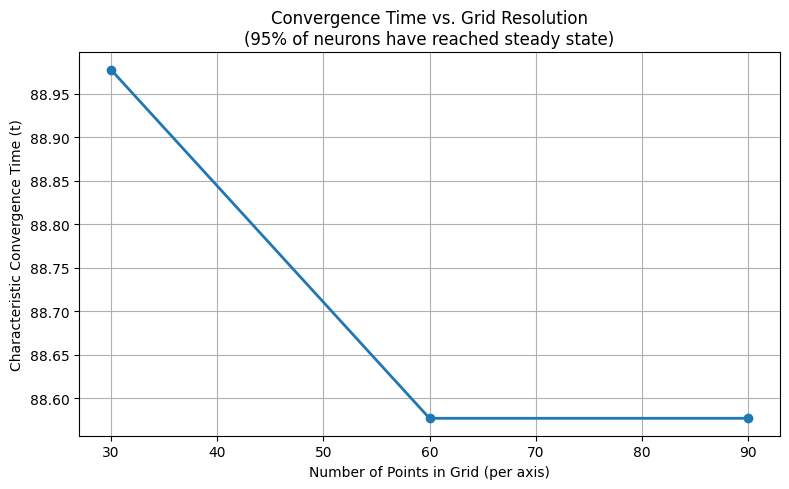

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm  # For progress bar

# --- Parameters (assumed defined elsewhere; include here if needed) ---
delta = 0.1
k_s = 0.02
b = 0.005

# Define your ODE
def dy_dt(t, y, delta, x1p, x1n, k_s):
    return y / (1 + y) - delta * y + 0.017 * x1p - (y * (b + 0.017 * x1n)) / (k_s + y)

# Noise parameters
noise_sigma = 0.2  # standard deviation of the Gaussian noise

# -----------------------------------------------------------------
# Define the range of grid resolutions to explore
# -----------------------------------------------------------------
grid_sizes = [30, 60, 90]
char_times = []  # Will store the characteristic convergence time for each grid resolution

# Loop over the different grid resolutions
for nb_points in grid_sizes:
    # Define the grid of neurons for the current grid resolution
    x1p_values = np.linspace(0, 10, nb_points)
    x1n_values = np.linspace(0, 10, nb_points)
    all_neurons = [(x1p, x1n) for x1p in x1p_values for x1n in x1n_values]
    
    # Set up integration parameters
    tf_single = 200
    t_eval_single = np.linspace(0, tf_single, 500)
    
    tol = 1e-2  # tolerance for convergence
    convergence_times = []  # list to store convergence time for each neuron

    print(f"\nProcessing grid with nb_of_points_grid = {nb_points} (total neurons: {len(all_neurons)})")
    
    # Loop over each neuron and compute its convergence time
    for x1p, x1n in tqdm(all_neurons, total=len(all_neurons), desc=f"Integrating for grid {nb_points}"):
        # Add Gaussian white noise to both parameters
        noisy_x1p = x1p + np.random.normal(loc=0, scale=noise_sigma)
        noisy_x1n = x1n + np.random.normal(loc=0, scale=noise_sigma)
        
        sol = solve_ivp(dy_dt, (0, tf_single), [1e-6],
                        args=(delta, noisy_x1p, noisy_x1n, k_s),
                        t_eval=t_eval_single,
                        method="RK45", rtol=1e-8, atol=1e-10)
        y_vals = sol.y[0]
        y_final = y_vals[-1]
        conv_time = tf_single  # default if no earlier time meets the criterion
        
        # Determine the convergence time for the current neuron
        for t_val, y_val in zip(sol.t, y_vals):
            if abs(y_val - y_final) < tol:
                conv_time = t_val
                break
        convergence_times.append(conv_time)
    
    # Compute the 95th percentile convergence time for this grid resolution
    grid_char_time = np.percentile(convergence_times, 95)
    char_times.append(grid_char_time)
    print(f"Grid size {nb_points}: 95% convergence reached at t ≈ {grid_char_time:.2f}")

# Plot the characteristic convergence time as a function of the grid resolution.
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(grid_sizes, char_times, marker="o", lw=2)
ax.set_xlabel("Number of Points in Grid (per axis)")
ax.set_ylabel("Characteristic Convergence Time (t)")
ax.set_title("Convergence Time vs. Grid Resolution\n(95% of neurons have reached steady state)")
ax.grid(True)
plt.tight_layout()
plt.show()


As expected, no significant size-effect, only a more and more precise estimation of the convergence time for the CRN to reaches its decided state (because when increasing neron number, even if one has more and more neuron near the demarcation line, one has way more and more neuron overall, so the ratio remains constant.)

*The response delay of the whole CRN is approximatively $\tau\approx 88 sc$ for 95% of neurons to have reached their steady state*


**(c) Percentage of decided neuron vs time**

Computing convergence times for grid with 2500 neurons...


Integrating neurons: 100%|██████████| 2500/2500 [00:31<00:00, 78.61it/s] 


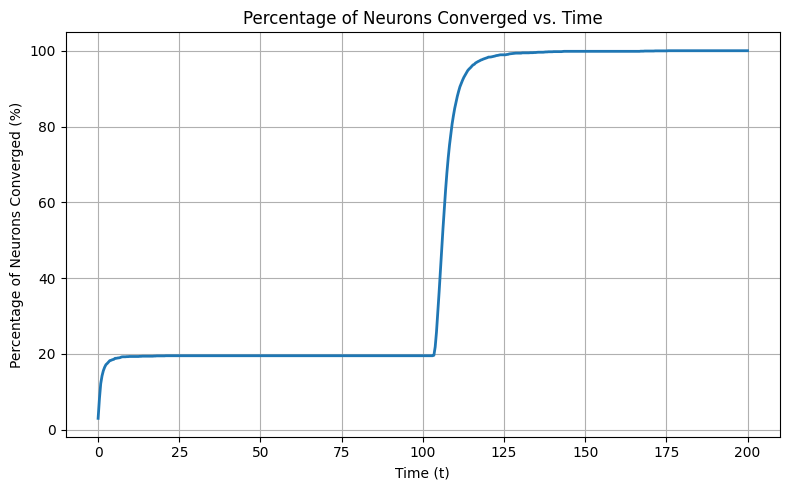

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm


# -----------------------------------------------------------------
# Set integration parameters for a fixed grid of neurons.
# -----------------------------------------------------------------
tf_single = 200
t_eval_single = np.linspace(0, tf_single, 500)

# Define a fixed grid of neurons.
nb_of_points_grid = 50  # Change as needed
x1p_values = np.linspace(0, 10, nb_of_points_grid)
x1n_values = np.linspace(0, 10, nb_of_points_grid)
all_neurons = [(x1p, x1n) for x1p in x1p_values for x1n in x1n_values]

tol = 1e-3  # tolerance level to consider a neuron converged

# -----------------------------------------------------------------
# Compute convergence times for each neuron.
# -----------------------------------------------------------------
convergence_times = []  # list to store convergence time for each neuron

print(f"Computing convergence times for grid with {nb_of_points_grid**2} neurons...")
for x1p, x1n in tqdm(all_neurons, total=len(all_neurons), desc="Integrating neurons"):
    sol = solve_ivp(dy_dt, (0, tf_single), [1e-6],
                    args=(delta, x1p, x1n, k_s),
                    t_eval=t_eval_single,
                    method="RK45", rtol=1e-8, atol=1e-10)
    y_vals = sol.y[0]

    # Define the steady state value as the final value from the integration.
    y_final = y_vals[-1]
    conv_time = tf_single  # default value if neuron doesn't converge early
    for t_val, y_val in zip(sol.t, y_vals):
        if abs(y_val - y_final) < tol:
            conv_time = t_val
            break
    convergence_times.append(conv_time)

convergence_times = np.array(convergence_times)

# -----------------------------------------------------------------
# Compute the percentage of neurons converged as a function of time.
# For a set of time points, count the fraction of neurons that have converged.
# -----------------------------------------------------------------
time_grid = np.linspace(0, tf_single, 500)
percentage_converged = []

for t in time_grid:
    # Count neurons with convergence time less than or equal to t.
    count = np.sum(convergence_times <= t)
    percentage = 100 * count / len(convergence_times)
    percentage_converged.append(percentage)

# -----------------------------------------------------------------
# Plot the percentage of neurons converged as a function of time.
# -----------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(time_grid, percentage_converged, lw=2)
ax.set_xlabel("Time (t)")
ax.set_ylabel("Percentage of Neurons Converged (%)")
ax.set_title("Percentage of Neurons Converged vs. Time")
ax.grid(True)
plt.tight_layout()
plt.show()



It seems that there is a phase transition. We should not be surprized, as all is deterministic, all neurones takes roughly the same time scale to reach the decided state.

**(d) Convergence time of each neuron wrt its input values**

Now, we would like to plot the phase diagram, but instead of coloring neurons wrt to their decided state, we color them wrt the time it takes them to reaches their decided state. In other words, we want to probe regions where the convergence toward ss is slow.

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm  # For progress bar
from itertools import product
from matplotlib.collections import LineCollection

# --- Parameters ---
delta = 0.1
k_s = 0.02
b = 0.005

# ODE definition: given x1p and x1n parameters in the rate functions
def dy_dt(t, y, delta, x1p, x1n, k_s):
    return y / (1 + y) - delta * y + 0.017 * x1p - (y * (b + 0.017 * x1n)) / (k_s + y)

# Integration helper function that returns the time when y converges toward its final value.
def integrate_ode_conv_time(x1p, x1n, y0, t_span, t_eval=None, tol=1e-3):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 2000)
    sol = solve_ivp(dy_dt, t_span, [y0],
                    args=(delta, x1p, x1n, k_s),
                    t_eval=t_eval,
                    method='RK45', rtol=1e-8, atol=1e-10)
    y_series = sol.y[0]
    y_final = y_series[-1]
    # Default convergence time is the final time, unless an earlier time is found
    convergence_time = t_span[1]
    for t_val, y_val in zip(sol.t, y_series):
        if abs(y_val - y_final) < tol:
            convergence_time = t_val
            break
    return convergence_time

# Correct Discriminant Function Δ(x1n, x1p)
def discriminant(x1p, x1n):
    return (0.000135648
            + 8.3521e-8 * x1n**4
            + x1n**3 * (-0.0000108676 - 3.30743e-7 * x1p)
            + x1n**2 * (0.00024844 + (0.0000318443 + 4.91137e-7 * x1p) * x1p)
            + x1n * (-0.000361051 + x1p * (-0.00044181 + (-0.0000310883 - 3.24128e-7 * x1p) * x1p))
            + x1p * (-0.000607421 + x1p * (0.000193247 + (0.0000101115 + 8.02136e-8 * x1p) * x1p)))

# --- Parameter grid for numerical integration (for the full phase diagram) ---
nb_of_points = 50
x1p_grid = np.linspace(0, 10, nb_of_points)
x1n_grid = np.linspace(0, 10, nb_of_points)

# Noise parameters
noise_sigma = 0.2  # standard deviation of the Gaussian white noise

# Time span and initial condition for the ODE
t_span_full = (0, 150)
y0 = 1e-6  # initial concentration
tol = 1e-3  # tolerance for convergence

# --- Generate data ---
# For each grid point (with added noise) compute the convergence time.
results = []  # to store (noisy x1p, noisy x1n, convergence time)
for x1p, x1n in tqdm(product(x1p_grid, x1n_grid), total=nb_of_points**2):
    # Add independent Gaussian white noise to each grid coordinate
    noisy_x1p = x1p + np.random.normal(loc=0, scale=noise_sigma)
    noisy_x1n = x1n + np.random.normal(loc=0, scale=noise_sigma)
    
    # Integrate the ODE dynamics with the noisy parameters and compute convergence time.
    conv_time = integrate_ode_conv_time(noisy_x1p, noisy_x1n, y0, t_span=t_span_full, tol=tol)
    
    results.append((noisy_x1p, noisy_x1n, conv_time))

results = np.array(results)
x1p_plot = results[:, 0]
x1n_plot = results[:, 1]
conv_time_plot = results[:, 2]



  0%|          | 0/2500 [00:00<?, ?it/s]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14928\2376453320.py:18: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(X1N, X1P, delta_vals_masked, levels=[0], colors='r', linewidths=1,alpha=0.5,


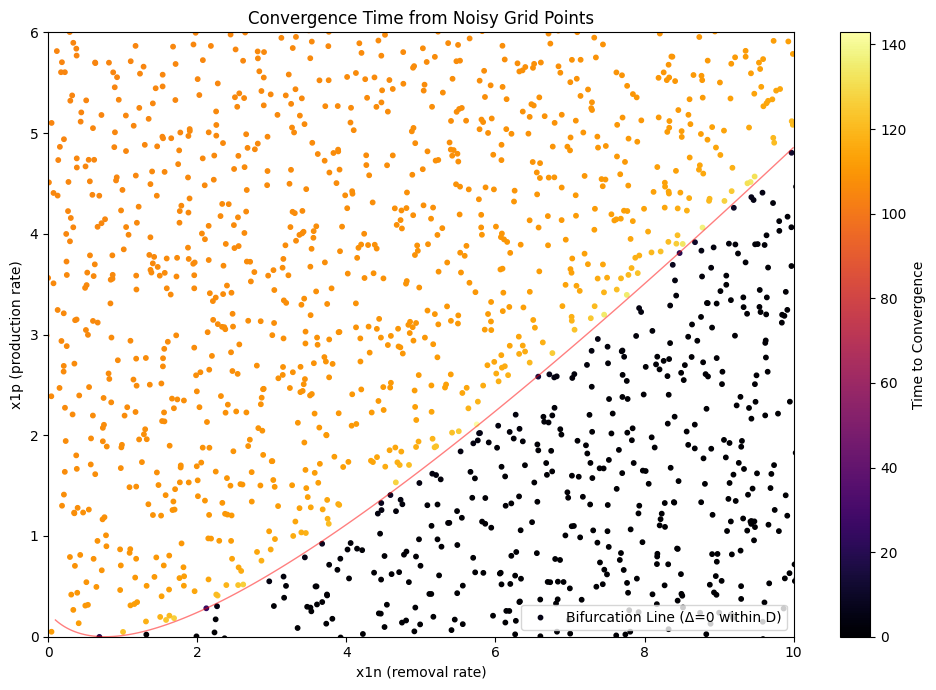

<Figure size 640x480 with 0 Axes>

In [38]:
# --- Plot the phase diagram using the noisy grid points ---
fig, ax = plt.subplots(figsize=(10, 7))
sc = ax.scatter(x1n_plot, x1p_plot, c=conv_time_plot, cmap='inferno', s=10, marker='o')
ax.set_title("Convergence Time from Noisy Grid Points")
ax.set_xlabel("x1n (removal rate)")
ax.set_ylabel("x1p (production rate)")
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Time to Convergence")

# Overlay the bifurcation line (Δ(x1n, x1p) = 0) based on the original grid:
a = 2  # Domain condition parameter: x1p - a*x1n < 0
x1n_vals = np.linspace(0, 10, 1000)
x1p_vals = np.linspace(0, 10, 1000)
X1N, X1P = np.meshgrid(x1n_vals, x1p_vals)
delta_vals = discriminant(X1P, X1N)
domain_mask = (X1P - a * X1N) < 0
delta_vals_masked = np.ma.array(delta_vals, mask=~domain_mask)
ax.contour(X1N, X1P, delta_vals_masked, levels=[0], colors='r', linewidths=1,alpha=0.5, 
           label="Bifurcation Line (Δ=0 within D)")

ax.legend(["Bifurcation Line (Δ=0 within D)"])

# Définir des limites restreintes pour le diagramme de phase :
ax.set_xlim(0, 10)   # Affiche x1n entre 2 et 8
ax.set_ylim(0, 6)   # Affiche x1p entre 2 et 6

plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()


Neurons whose concentration fall near the demarcation line takes significantly more time to converge toward their decided state, which can be interpreted as the simultaneous coexistence of the 2 bassin of  attraction (oof and on). A point exactly on the demarcation line would be in an unstable equilibrium of undecided state. Yet, the proba to fall exactly on this point is 0, so we end up converging toward 'on' or 'off' state. Futhermore, a low sum of input is not link to any increase in decision time. This is in good agreement with experimental outcomes.

Rmq : one could also perform a stability analysis y=y*+\delta u to see how long does it takes to return to the fp y*.